# Metrics

Implement metrics to evaluate clustering performance based on BCubed.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|C(i)|} \sum_{j \in C(i)}B(i, j)
$$

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{j \in L(i)}B(i, j)
$$

Where $C(i)$ is the cluster (trackster) that contains layercluster $i$, and $L(i)$ are all layerclusters of the same subject (simtrackster) as layercluster $i$.

$B(i,j)$ is:
- 1 (a fraction as layerclusters can be shared by different tracksters)
    - if a pair of layerclusters $(i, j)$ of the same subject (simtrackster) are in the same cluster (trackster)
- 0 otherwise

Then the F-score is computed as:
$$
F_p = \frac{2P_bR_b}{P_b + R_b}
$$

## Multiple layerclusters per trackster

Each layer-cluster can be a part of multiple tracksters / simtracksters.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{|t|} \sum_{j \in t}B(i, j)
$$

Where $T(i)$ are the cluster**s** (trackster**s**) that contains layercluster $i$.

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|S(i)|} \sum_{s \in S(i)} \frac{1}{|s|} \sum_{j \in s}B(i, j)
$$

and $S(i)$ are all layerclusters of the same subject**s** (simtrackster**s**) as layercluster $i$.

## Energy-aware score

For each pair, multiply the score with the trackster energies:

$$
Pe_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{E(i, t)} \sum_{j \in t}B(i, j)E_t(i, j)
$$

Where $E(i, t)$ is the total energy of all trackster pairs between $i$ and $t$ and $E_t(i, j)$ is the layercluster pair energy of $i$ and $j$ in trackster $t$.

$$
Re_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|S(i)|} \sum_{s \in S(i)} \frac{1}{E(s)} \sum_{j \in s}B(i, j)E_s(i,j)
$$



In [2]:
import uproot
import awkward as ak
import numpy as np
from utils.plotting_utils import plot_event

file_name = "~/data/photon/new_ntuples_13872546_165.root"
# file_name = "~/data/multiparticle/new_ntuples_14132277_842.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Vertices in Tracksters and Simtracksters are in the same collection (with matching IDs).
- Not all vertices are present in the reconstruction

In [3]:

print(max(ak.flatten(tracksters["vertices_indexes"].array()[1])))
print(max(ak.flatten(simtracksters["stsSC_vertices_indexes"].array()[1])))
print(tracksters["NClusters"].array()[1])

368
376
377


Use the trackster energy (in TeV)

In [4]:
def get_map(tree, eid):
    i2o = {}
    for st_idx, st in enumerate(tree.array()[eid]):
        for i in st:
            if i in i2o:
                i2o[i].append(st_idx)
            else:
                i2o[i] = [st_idx]
    return i2o

def get_E_map(tree, e_tree):
    # create map: trackster -> vertex -> energy
    v2e = {}
    for t_idx in range(len(tree)):
        for i, e in zip(tree[t_idx], e_tree[t_idx]):
            if t_idx in v2e:
                v2e[t_idx][i] = e
            else:
                v2e[t_idx] = {i: e}
    return v2e

In [5]:
def B(i, j, mapping):
    # assumes i and j are in the same trackster/simtrackster
    mi = mapping[i]
    mj = mapping[j]
    match = np.intersect1d(mi, mj)
    f_i = len(match) / len(mi)
    f_j = len(match) / len(mj)

    # XXX: return average of the intersect fractions (is this right?)
    return (f_i + f_j) / 2

def get_pairwise_scores(i, V, i2t, te_map):
    """
    Compute the score per trackster/simtrackster
    normalized by the number of pairs or total pair energy
    Inputs:
        i       target LC 
        V       L or C - all LCs of the trackster or simtrackster
        i2t     mapping from LC to it's trackster or simtracksters on the oposite side
        te_map  (optional) LC -> energy in the given trackster
    Output:
        Normalized sum of the pair-wise scores
    """
    e_pairs = 0
    i_trackster_score = 0
    # for all vertices of the trackster
    for j in V:
        pair_score = B(i, j, i2t)
        if te_map:
            # multiply the score by the pair energy
            e_pair = te_map[i] * te_map[j]
            pair_score *= e_pair
            e_pairs += e_pair
        i_trackster_score += pair_score
        
    if e_pairs:
        return i_trackster_score / e_pairs
    return i_trackster_score / len(V)


def bcubed(vertices, t_vertices, i2a, i2b, e_map=None):
    """
    Base algorithm for bcubed precision and recall
    Input:
        vertices: all layerclusters in the event
        t_vertices:
            precision: trackster to layercluster mapping
            recall: simtrackster to layercluster mapping
        i2a, i2b:
            precision: 
                layercluster to tracksters map
                layercluster to simtracksters map
            recall: reverse order (i2b, i2a)
        e_map (optional):
            precision: LC to energy in a trackster
            recall: LC to energy in a simtrackster
    Returns: precision / recall for the given input
    """
    P = 0
    # for all reco/sim vertices
    for i in vertices:
        i_score = 0

        # get all tracksters/simtracksters i is in
        i_tracksters = i2a[i]

        # normalize by the fraction of tracksters/simtracksters the particle is in 
        # or by the energy share if e_map is defined
        t_sum = sum([e_map[it][i] for it in i_tracksters]) if e_map else len(i_tracksters)

        # get score for each trackster/simtrackster i is in
        for i_trackster in i_tracksters:
            # intersection required for recall (as the points are filtered)
            V = np.intersect1d(t_vertices[i_trackster], vertices)
            te_map = e_map[i_trackster] if e_map else None
            t_weight = e_map[i_trackster][i] if e_map else 1
            i_score += t_weight * get_pairwise_scores(i, V, i2b, te_map)

        # normalize add to the outer P sum
        P += i_score / t_sum

    # normalize the result
    return P / len(vertices)

def f_score(A, B):
    return (2 * A * B) / (A + B)

In [6]:
def get_scores(eid, energy=False):
    i2rt = get_map(tracksters["vertices_indexes"], eid)
    i2st = get_map(simtracksters["stsSC_vertices_indexes"], eid)
    t_vertices = ak.flatten(tracksters["vertices_indexes"].array()[eid])
    t_indexes = tracksters["vertices_indexes"].array()[eid]
    st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
    te_map = get_E_map(tracksters["vertices_indexes"].array()[eid], tracksters["vertices_energy"].array()[eid])         
    ste_map = get_E_map(simtracksters["stsSC_vertices_indexes"].array()[eid], simtracksters["stsSC_vertices_energy"].array()[eid])
    precision = bcubed(t_vertices, t_indexes, i2rt, i2st, e_map=te_map if energy else None)
    recall = bcubed(t_vertices, st_indexes, i2st, i2rt, e_map=ste_map if energy else None)
    return precision, recall, f_score(precision, recall)

[N] Precision: 0.83, Recall: 0.32, F-score: 0.46
[E] Precision: 0.87, Recall: 0.35, F-score: 0.50


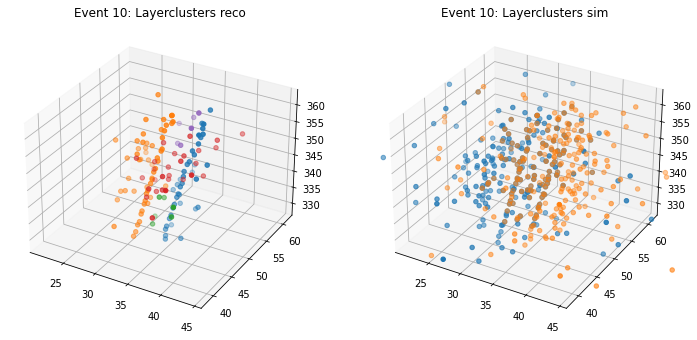

In [8]:
eid = 10
precision, recall, fscore = get_scores(eid)
print(f"[N] Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

precision_e, recall_e, fscore_e = get_scores(eid, energy=True)
print(f"[E] Precision: {precision_e:.2f}, Recall: {recall_e:.2f}, F-score: {fscore_e:.2f}")
plot_event(tracksters, simtracksters, eid, legend=False)